Mounted at /content/drive


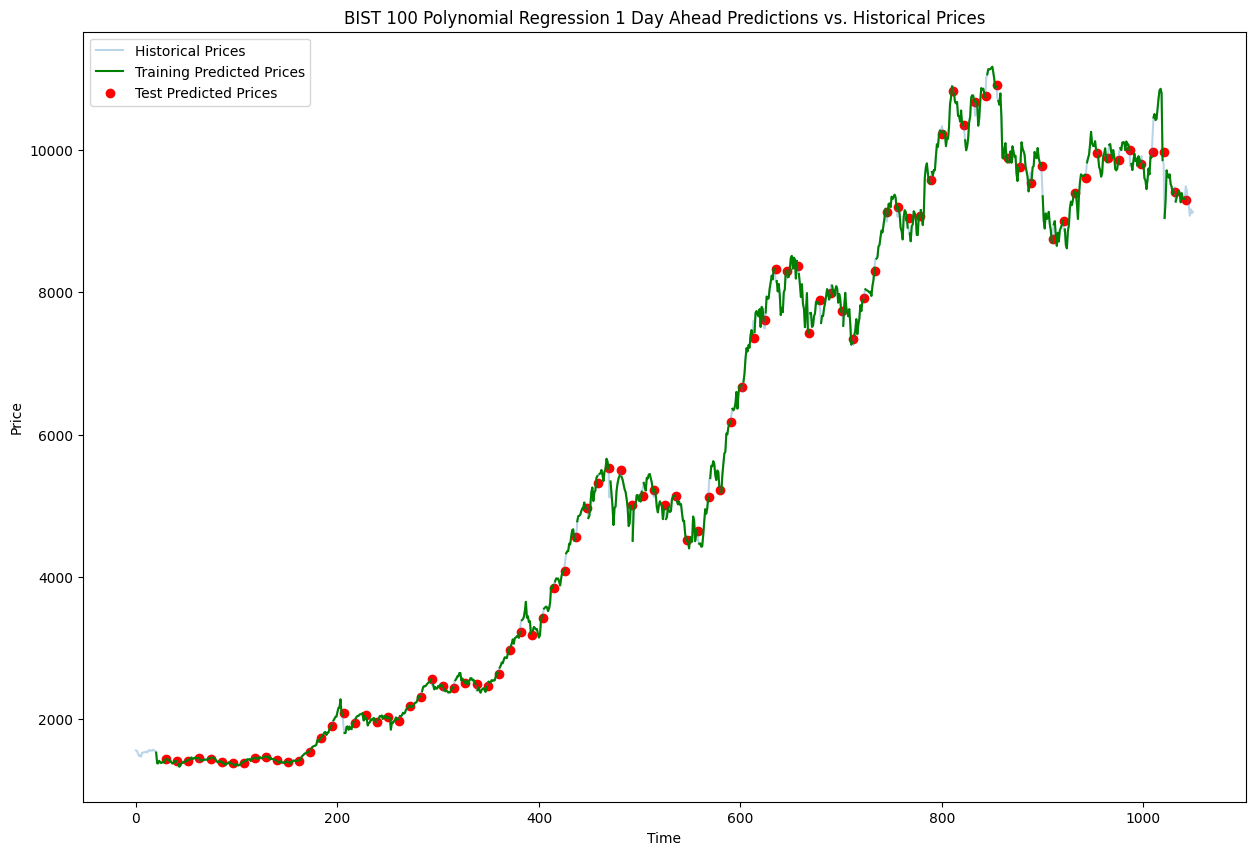

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures,StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


X = pd.read_csv("Xtable.csv")
y = X.iloc[:,-1].values
X = X.iloc[:,1:].values

window_size = 20;
step_size = 1;

X_win_all = []
y_win_all = []

for i in range(0,len(X)-window_size-1,step_size):
  X_win = X[i:i+window_size]
  y_win = y[i+window_size]
  X_win_all.append(X_win)
  y_win_all.append(y_win)

X_win_all=np.array(X_win_all)
y_win_all=np.array(y_win_all)

# Although called val, all variables with val is for testing, because we train a model from scratch in every walk
X_trainval = X_win_all[:]
y_trainval = y_win_all[:]

# Walk forward Validation
shift_win = 11

# In a single walk
n_train = 10
n_valid = 1

poly_deg = 1

pred_train_all = []
pred_val_all = []

true_train_all = []
true_val_all = []

rmse_train_per_walk = []
rmse_val_per_walk = []

train_idx_all = []
val_idx_all = []

# Coloumns to be normalized
cols_N = np.concatenate([np.arange(8,37),np.array([38,39,41,42,44,45,47,48,50,51,53,54,56,57,58])])

for start_idx in range(0, len(X_trainval)-n_train-n_valid+1,shift_win):

  X_train = X_trainval[start_idx:start_idx+n_train]
  y_train = y_trainval[start_idx:start_idx+n_train]

  X_val = X_trainval[start_idx+n_train:start_idx+n_train+n_valid]
  y_val = y_trainval[start_idx+n_train:start_idx+n_train+n_valid]

  # Normalization
  normalizer_y = MinMaxScaler(feature_range=(-1, 1))
  normalizer_X = {}

  for k in cols_N:
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_train_k = X_train[:,:,k].reshape(-1,1)
    X_train_scaled = scaler_X.fit_transform(X_train_k)
    X_train[:,:,k] = X_train_scaled.reshape(X_train[:,:,k].shape)
    normalizer_X[k] = scaler_X

  for k in cols_N:
    X_val_k = X_val[:,:,k].reshape(-1,1)
    X_val_scaled = normalizer_X[k].transform(X_val_k)
    X_val[:,:,k] = X_val_scaled.reshape(X_val[:,:,k].shape)


  y_train = normalizer_y.fit_transform(y_train.reshape(-1,1))
  y_val = normalizer_y.transform(y_val.reshape(-1,1))


  X_train_flat =  X_train.reshape(X_train.shape[0],-1)
  X_val_flat = X_val.reshape(X_val.shape[0],-1)

 # fitting

  poly_f = PolynomialFeatures(degree=poly_deg)
  X_train_poly = poly_f.fit_transform(X_train_flat)
  X_val_poly = poly_f.transform(X_val_flat)

  mdl = LinearRegression()

  mdl.fit(X_train_poly,y_train)

  train_pred = mdl.predict(X_train_poly).flatten()
  val_pred  = mdl.predict(X_val_poly).flatten()

  train_pred = normalizer_y.inverse_transform(train_pred.reshape(-1,1)).flatten()
  val_pred = normalizer_y.inverse_transform(val_pred.reshape(-1,1)).flatten()

  pred_train_all.append(train_pred)
  pred_val_all.append(val_pred)

  true_train = normalizer_y.inverse_transform(y_train.reshape(-1,1)).flatten()
  true_val = normalizer_y.inverse_transform(y_val.reshape(-1,1)).flatten()

  true_train_all.append(true_train)
  true_val_all.append(true_val)

  train_idx = list(range(start_idx + window_size, start_idx + window_size + n_train))
  val_idx = list(range(start_idx + n_train + window_size, start_idx + n_train + window_size + n_valid))

  train_idx_all.append(train_idx)
  val_idx_all.append(val_idx)

  rmse_train_per_walk.append(np.sqrt(mean_squared_error(train_pred,true_train)))
  rmse_val_per_walk.append(np.sqrt(mean_squared_error(val_pred,true_val)))


# Plotting

plt.figure(figsize=(15,10))

plt.plot(range(len(y)),y, label='Historical Prices', alpha=0.3)

for i in range(len(pred_train_all)):
  if i >= 1:
    plt.plot(train_idx_all[i],pred_train_all[i], color="green")
  else:
    plt.plot(train_idx_all[i],pred_train_all[i], label='Training Predicted Prices', color="green")

for i in range(len(pred_val_all)):
  if i >= 1:
    plt.scatter(val_idx_all[i],pred_val_all[i], color="red")
  else:
    plt.scatter(val_idx_all[i],pred_val_all[i], label='Test Predicted Prices', color="red")


plt.title('BIST 100 Polynomial Regression 1 Day Ahead Predictions vs. Historical Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
pred_err_val = []
true_err_val = []

for i in range(len(pred_val_all)):
  idx = [idx for idx in val_idx_all[i] if idx < len(y)]
  pred_err_val.extend(pred_val_all[i].flatten()[:len(idx)])
  true_err_val.extend(y[idx])

rmse_val_err = np.sqrt(mean_squared_error(pred_err_val,true_err_val))
r2_val_err = r2_score(pred_err_val,true_err_val)
mae_val_err = mean_absolute_error(pred_err_val,true_err_val)
mape_val_err = mean_absolute_percentage_error(pred_err_val,true_err_val)
acc_val_err = (1-mae_val_err/np.mean(true_err_val))*100

pred_err_train = []
true_err_train = []

for i in range(len(pred_train_all)):
  idx = [idx for idx in train_idx_all[i] if idx < len(y)]
  pred_err_train.extend(pred_train_all[i].flatten()[:len(idx)])
  true_err_train.extend(y[idx])

rmse_train_err = np.sqrt(mean_squared_error(pred_err_train,true_err_train))
r2_train_err = r2_score(pred_err_train,true_err_train)
mae_train_err = mean_absolute_error(pred_err_train,true_err_train)
mape_train_err = mean_absolute_percentage_error(pred_err_train,true_err_train)
acc_train_err = (1-mae_train_err/np.mean(true_err_train))*100

print(f"TRAIN RMSE: {rmse_train_err}")
print(f"TRAIN R2: {r2_train_err}")
print(f"TRAIN MAE: {mae_train_err}")
print(f"TRAIN MAPE: {mape_train_err}")
print(f"TRAIN ACC: {acc_train_err}")

print(f"TEST RMSE: {rmse_val_err}")
print(f"TEST R2: {r2_val_err}")
print(f"TEST MAE: {mae_val_err}")
print(f"TEST MAPE: {mape_val_err}")
print(f"TEST ACC: {acc_val_err}")

TRAIN RMSE: 3.300857253231232e-13
TRAIN R2: 1.0
TRAIN MAE: 9.535025099232313e-14
TRAIN MAPE: 1.7851111716585175e-17
TRAIN ACC: 100.0
TEST RMSE: 113.78894587932699
TEST R2: 0.9988363168156089
TEST MAE: 85.64411075396366
TEST MAPE: 0.016186862970973416
TEST ACC: 98.49962852868649


In [3]:
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat - pred_val_all_flat

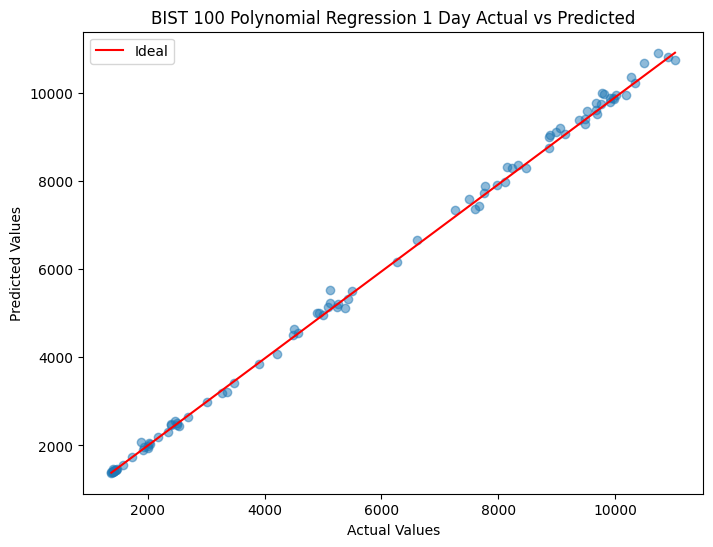

In [4]:
plt.figure(figsize=(8,6))

plt.scatter(true_val_all_flat, pred_val_all_flat, alpha=0.5)
plt.plot([min(true_val_all_flat),max(true_val_all_flat)],[min(pred_val_all_flat),max(pred_val_all_flat)],"r", label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("BIST 100 Polynomial Regression 1 Day Actual vs Predicted")
plt.legend()
plt.show()

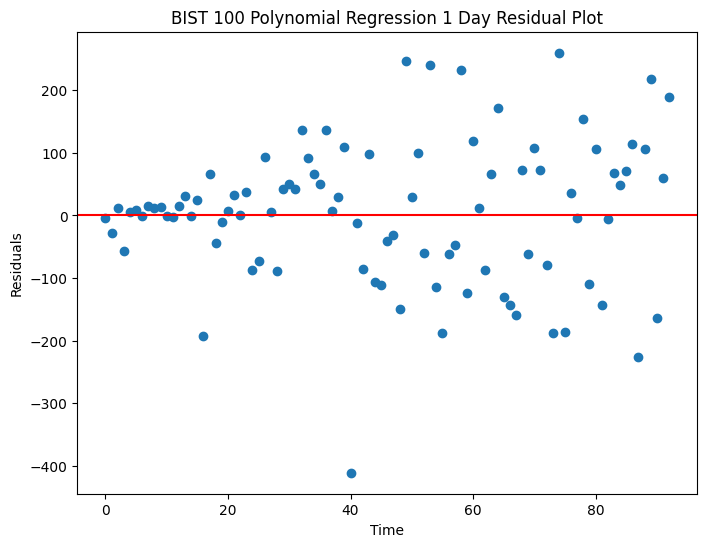

In [7]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res)),res)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 Polynomial Regression 1 Day Residual Plot")
plt.show()
